<a href="https://colab.research.google.com/github/CJP123/hut8/blob/master/_notebooks/2020_08_27_Captcha_Fastai_DataBlock_and_CTC_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This example builds on a couple of great tutorials that demonstrate a simple OCR models. One in Keras by [Aakash Kumar Nain](https://keras.io/examples/vision/captcha_ocr/) and a very helpful conversion to pytorch by [
Abhishek Thakur](https://www.youtube.com/watch?v=IcLEJB2pY2Y). I wanted to get a working knowledge of the CTC loss and also practice using a custom [FastAI](https://docs.fast.ai/tutorial.datablock) datablock

In [ ]:
!pip install -U fastai --quiet

     |████████████████████████████████| 358kB 2.8MB/s 


Lets download and look at one of the images from the dataset

In [ ]:
from fastai.vision.all import *
from itertools import groupby

In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    228      0 --:--:-- --:--:-- --:--:--   228
100 8863k  100 8863k    0     0  3719k      0  0:00:02  0:00:02 --:--:-- 17.7M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


8g4yp.png


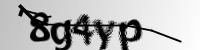

In [ ]:
#hide
path = Path('captcha_images_v2') 
fns = get_image_files(path) 
print(fns[0].name)
Image.open(fns[0])

# Connectionist Temporal Classification (CTC) 
Is a loss mechanism that is a way to get around not knowing the alignment between the input and the output. The filenames set out the Captcha image letters. In this dataset all the images are 5 characters long but as detailled in the linked paper [CTC Loss](
https://distill.pub/2017/ctc/) this is not essential and CTC loss can manage variable length targets.

# Fastai Datablock
This problem requires an ordered target reflecting the characters which is not a default datablock option. I was keen to see how easy it was to generate one that could be used for this problem - the CaptchaBlock

In [ ]:
class TensorCaptcha(TensorCategory): pass #Create a Tensor 

def CaptchaBlock(vocab=None):
    "`TransformBlock` for Captcha categorical targets"
    tfm = CaptchaCategorize(vocab=vocab)
    return TransformBlock(type_tfms=tfm)

class CaptchaCategorize(Categorize):
    "Transform of encoded Captcha-category that decodes with `vocab`"
    def __init__(self, vocab=None, sort=True, add_na=False):
        store_attr(self, self.store_attrs+',sort')
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
    
    def encodes(self, o): 
      return TensorCaptcha(torch.stack([tensor(self.vocab.o2i[x]) for x in o])) #generates a new tensor encoding the labels 

    def decodes(self, o): 
      return CaptchaCategory(('').join([Category(self.vocab[x]) for x in o])) #decodes the TensorCaptcha and returns a clean string

class CaptchaCategory(L):
    def show(self, ctx=None, sep=';', color='black', **kwargs):
        return show_title(sep.join(self.map(str)), ctx=ctx, color=color, **kwargs)


I am not certain that this code utilises all the fastai functionalyity but it is sufficient for the purposes of this experiment

#

(#20) ['.','m','7','e','n','g','p','x','c','3'...]

In [ ]:
# class TensorCaptcha(TensorCategory): pass #Create a Tensor 

# class CategorizeCaptcha(Transform): #DisplayedTransform
#     "Reversible transform of category string to `vocab` id"
#     loss_func,order,store_attrs=CrossEntropyLossFlat(),1,'vocab,add_na'
#     def __init__(self, vocab=None, sort=True, add_na=False):
#         store_attr(self, self.store_attrs+',sort')
#         self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)

#     def setups(self, dsets):
#         if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
#         self.c = len(self.vocab)

#     def encodes(self, o): 
#       return TensorCaptcha(torch.stack([tensor(self.vocab.o2i[x]) for x in o]))
#     def decodes(self, o): 
#       return ('').join([Category(self.vocab[x]) for x in o])# [dls.vocab[x]) for x in preds]

# def CaptchaBlock(vocab=None, sort=True, add_na=False):
#     "`TransformBlock` to split label into ordered label categorical targets"
#     return TransformBlock(type_tfms=CategorizeCaptcha(vocab=vocab, sort=sort, add_na=add_na))

In [ ]:
# class Captcha(Transform): #DisplayedTransform
#     "Reversible transform of category string to `vocab` id"
#     loss_func,order,store_attrs=CrossEntropyLossFlat(),1,'vocab,add_na'
#     def __init__(self, vocab=None, sort=True, add_na=False):
#         store_attr(self, self.store_attrs+',sort')
#         self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)

#     def setups(self, dsets):
#         if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort, add_na=self.add_na)
#         self.c = len(self.vocab)

#     def encodes(self, o): 
#       return TensorCaptcha([tensor(self.vocab.o2i[x]) for x in o])

#     def decodes(self, o): 
#       return ('').join([Category(self.vocab[x]) for x in o])

In [ ]:
# tfm = CaptchaBlock(vocab=vocab)
# raw = stm(fns[0])
# encoded = tfm(raw)
# decoded = tfm.decode(encoded)
# assert(raw == decoded)
# print('Input: ', raw)
# print('Encoded: ', encoded)
# print('Decoded: ', decoded)

TypeError: ignored

# Datablock
Set up a new dataloader using the new CaptchaBlock

In [ ]:
def stem_label(o): return o.stem

In [ ]:
# Set up the required vocab from the filenames titles. 
# '.' has been added to the front of the vocab to represent the "blank" or null character 
vocab = L('.')+L(set([x for x in ('').join([x.stem for x in fns])]))
vocab

(#20) ['.','w','m','2','c','7','4','d','n','3'...]

In [ ]:
captcha = DataBlock(blocks =(ImageBlock(cls=PILImageBW), (CaptchaBlock(vocab=vocab))),
                 get_items=get_image_files, 
                 get_y = stem_label,
                 splitter=RandomSplitter(seed=42),      
                 item_tfms = Resize((75,300))
                )
dls = captcha.dataloaders(path, bs=8)

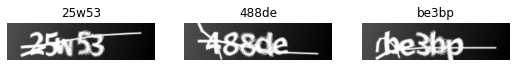

In [ ]:
dls.show_batch(max_n=3)

Look at the resulting tensors for one item

In [ ]:
x,y = dls.one_batch()
print(x[0],y[0])

tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]],
       device='cuda:0') tensor([ 8,  8, 19, 14, 19], device='cuda:0')


# First Model
My first model attempted to largely duplicates the approach and code used by [Abhishek](https://github.com/abhishekkrthakur/captcha-recognition-pytorch.git)

In [ ]:
class CaptchaModel(nn.Module):
  def __init__(self, num_chars=20):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(1, 128, kernel_size=(3, 3), padding=(1, 1))
    self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
    self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.linear_1 = nn.Linear(1152, 64)
    self.drop_1 = nn.Dropout(0.2)
    self.gru_1 = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25,batch_first=True)
    self.output = nn.Linear(64, num_chars)

  def forward(self, x, targets=None):
    # bs, c, h, w = x.size()
    x = F.relu(self.conv_1(x))          # bs, channels , height, width
    x = self.pool_1(x)
    x = F.relu(self.conv_2(x))          
    x = self.pool_2(x)                  
    x = x.permute(0, 3, 1, 2)           # change the width channel to 'time' channel order for input to the RNN
    x = x.view(x.size(0), x.size(1), -1)      
    x = F.relu(self.linear_1(x))        # 
    x = self.drop_1(x)                  # 
    x, _ = self.gru_1(x)                # 
    x = self.output(x)                  # 
    x = x.permute(1,0,2)                #  
    return x

In [ ]:
def ctc_loss(inputs, targets):
  inputs = inputs.permute(1,0,2)                
  log_probs = F.log_softmax(inputs, 2)
  input_lengths = torch.full(size=(inputs.size(1),), fill_value=inputs.size(0), dtype=torch.int32) # should be bs x rnn output
  target_lengths = torch.full(size=(inputs.size(1),), fill_value=tensor(5), dtype=torch.int32)
  loss = nn.CTCLoss(blank=0)(
          log_probs, targets, input_lengths, target_lengths
          )
  return loss

In [ ]:
# This function is a simple method to reduce duplicate consecutive predictions generated by the CTC loss model. 
# The following function removes any duplicates in groups but allows duplicates to be separated by the blank placeholder '.'
def strip_duplicates(str):
  return ('').join([x for x, y in groupby(str) if sum(1 for i in y) >0 if x != '.'])

def show_output():
  x,y=dls.valid.one_batch() #get a batch
  preds = learn.model(x) #get model predictions
  # preds = preds.permute(1, 0, 2) #permute the model to put the batches in order
  preds = torch.argmax(torch.softmax(preds, 2), 2)  
  decoded = [('').join(dls.vocab[x]) for x in preds]
  cleaned = [strip_duplicates(x) for x in decoded]
  results = zip(decoded,cleaned,[('').join(dls.vocab[x]) for x in y.detach().cpu().numpy()])
  print('Actual  | ',' '*31,'Prediction',' '*32,'| Cleaned ' )
  for res in results:
    print(res[2],'  | ',f'{res[0]} | ','.....' if len(res[1]) == 0 else res[1])

In [ ]:
learn = Learner(dls, CaptchaModel(20), loss_func=ctc_loss, cbs =ReduceLROnPlateau(patience=3))

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.002511886414140463)

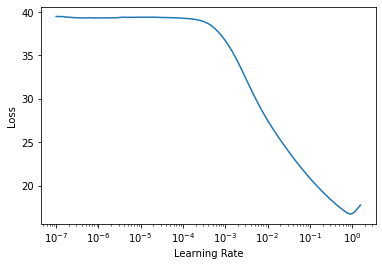

In [ ]:
learn.lr_find()

In [ ]:
#hide
learn.fit(100,1e-2)

epoch,train_loss,valid_loss,time
0,3.513356,3.296777,00:04
1,3.325741,3.284081,00:04
2,3.290609,3.233346,00:04
3,3.278223,3.253587,00:04
4,3.269069,3.211845,00:04
5,3.257792,3.227095,00:04
6,3.237562,3.211173,00:04
7,3.238216,3.220011,00:04
8,3.235154,3.230315,00:04
9,3.205783,3.245116,00:04


Epoch 9: reducing lr to 0.001
Epoch 38: reducing lr to 0.0001
Epoch 41: reducing lr to 1e-05
Epoch 44: reducing lr to 1.0000000000000002e-06
Epoch 47: reducing lr to 1.0000000000000002e-07


Nothing is produced after 50 epochs on the on the validation set.

In [ ]:
show_output()

Actual  |                                  Prediction                                  | Cleaned 
677g3   |  .................................................................n.n.n.n.n. |  nnnnn
wwmn6   |  .................................................................n.n.n.n.n. |  nnnnn
nybcx   |  .................................................................n.n.n.n.n. |  nnnnn
y866y   |  .................................................................n.n.n.n.n. |  nnnnn
fnbfw   |  .................................................................n.n.n.n.n. |  nnnnn
pg2yx   |  .................................................................n.n.n.n.n. |  nnnnn
n7g4f   |  .................................................................n.n.n.n.n. |  nnnnn
pcm7f   |  .................................................................n.n.n.n.n. |  nnnnn


# CNN Only Model
The model above combines a CNN and RNN. The CNN is permuted and reshaped before entering the RNN so that it already should have some sense of "time" order to feed into the CTC loss even without the RNN. This model will remove the RNN from the model and see if can still learn.

In [ ]:
class CaptchaModel2(nn.Module):
  def __init__(self, num_chars=20):
    super(CaptchaModel2, self).__init__()
    self.conv_1 = nn.Conv2d(1, 128, kernel_size=(3, 3), padding=(1, 1))
    self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
    self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.drop_1 = nn.Dropout(0.2)
    self.linear_1 = nn.Linear(1152, 128)
    self.output = nn.Linear(128, num_chars)

  def forward(self, x, targets=None):
    x = F.relu(self.conv_1(x))          # bs, channels , height, width
    x = self.pool_1(x)
    x = F.relu(self.conv_2(x))          
    x = self.pool_2(x)                  
    x = x.permute(0, 3, 1, 2)           # change the width channel to , h, c
    x = x.view(x.size(0),x.size(1),-1)  # 16, 50, 768    bs, w, hc
    x = F.relu(self.linear_1(x))        # 16, 50, 128    bs, w, hc
    x = self.drop_1(x)                  # 16, 50, 19+1    bs, w, hc
    x = self.output(x)                  # 16, 50, 19+1    bs, w, hc
    return x

In [ ]:
learn = Learner(dls, CaptchaModel2(20), loss_func=ctc_loss, cbs=ReduceLROnPlateau(patience=3))

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0003981071640737355)

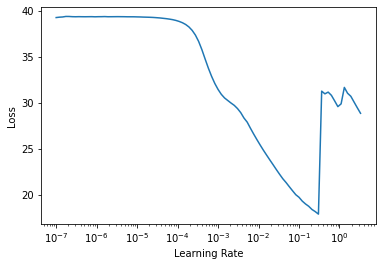

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(50,1e-3)

epoch,train_loss,valid_loss,time
0,0.373616,0.335259,00:02
1,0.378223,0.287420,00:02
2,0.338104,0.272776,00:02
3,0.318468,0.272740,00:02
4,0.328818,0.263506,00:02
5,0.305960,0.263038,00:02
6,0.301829,0.281372,00:02
7,0.285233,0.262878,00:02
8,0.293329,0.247991,00:02
9,0.293683,0.252269,00:02


Epoch 11: reducing lr to 0.0001
Epoch 15: reducing lr to 1e-05
Epoch 26: reducing lr to 1.0000000000000002e-06
Epoch 29: reducing lr to 1.0000000000000002e-07
Epoch 32: reducing lr to 1.0000000000000002e-08
Epoch 35: reducing lr to 1.0000000000000003e-09
Epoch 38: reducing lr to 1.0000000000000003e-10
Epoch 41: reducing lr to 1.0000000000000003e-11
Epoch 44: reducing lr to 1.0000000000000002e-12
Epoch 47: reducing lr to 1.0000000000000002e-13


In [ ]:
show_output()

Actual  |                                  Prediction                                  | Cleaned 
677g3   |  .................6...77......7..........g......3........................... |  677g3
wwmn6   |  ............w........ww.....................n.......6...................... |  wwn6
nybcx   |  ............n........yy.....bb..........cc......x.......................... |  nybcx
y866y   |  ..............y...........8........6.......66....y......................... |  y866y
fnbfw   |  .............f.............b.........f......w.............................. |  fbfw
pg2yx   |  ............p............g...2.......yy..........x......................... |  pg2yx
n7g4f   |  .....................7..........g.......4.....f............................ |  7g4f
pcm7f   |  ............p...........cc.......nn.......7......f......................... |  pcn7f
